In [1]:
import pandas as pd
import matplotlib
import numpy as np
import geopandas as gpd

data prep

### 1. number of units res per census tract 

In [2]:
units_census = pd.read_csv('units_census.csv', converters={'census_fips': lambda x: str(x).zfill(9)})

In [3]:
units_census['GEO_ID'] = units_census['census_fips'].apply(lambda x: f"1400000US36{x}")

In [20]:
units_census .head()

,Borough,2010 Census FIPS County Code,2010 DCP Borough Code,2010 Census Tract,Total Occupied Housing Units,census_fips,GEO_ID
0,Bronx,5,2,100,0,005000100,1400000US36005000100
1,Bronx,5,2,200,"1,351",005000200,1400000US36005000200
2,Bronx,5,2,400,"1,786",005000400,1400000US36005000400
3,Bronx,5,2,1600,"1,925",005001600,1400000US36005001600
4,Bronx,5,2,1900,550,005001900,1400000US36005001900


### 2. load income and violation file

In [4]:
income_viol = pd.read_csv('income_violation.csv')

In [21]:
income_viol .head()

,GEO_ID,CENSUSAREA,income_change_field_1,income_change_Geo_FIPS,income_change_SE_T058_001,income_change_SE_T058_010,income_change_prec_change,NUMPOINTS
0,1400000US36001000100,0.914,NaN,NaN,NaN,NaN,NaN,0
1,1400000US36001000200,0.797,NaN,NaN,NaN,NaN,NaN,0
2,1400000US36001000401,3.482,NaN,NaN,NaN,NaN,NaN,0
3,1400000US36001000501,0.211,NaN,NaN,NaN,NaN,NaN,0
4,1400000US36001001500,0.225,NaN,NaN,NaN,NaN,NaN,0


### 3. merge

In [5]:
income_viol_units = pd.merge(income_viol,units_census, on='GEO_ID', how='inner') 

In [6]:
len(income_viol_units)

2167

In [23]:
income_viol_units .head()

,GEO_ID,CENSUSAREA,income_change_field_1,income_change_Geo_FIPS,income_change_SE_T058_001,income_change_SE_T058_010,income_change_prec_change,NUMPOINTS,Borough,2010 Census FIPS County Code,2010 DCP Borough Code,2010 Census Tract,Total Occupied Housing Units,census_fips,norm_viol
1,1400000US36005000200,0.176,1.0,1.645262e+09,59826.0,25441.0,-57.47501,223,Bronx,5,2,200,"1,351",005000200,16.506292
2,1400000US36005000400,0.352,2.0,1.645262e+09,71968.0,19620.0,-72.73788,191,Bronx,5,2,400,"1,786",005000400,10.694289
5,1400000US36005004001,0.048,17.0,1.645266e+09,44432.0,44318.0,-0.25657,62,Bronx,5,2,4001,536,005004001,11.567164
9,1400000US36005006400,0.063,30.0,1.645268e+09,42596.0,53750.0,26.18556,220,Bronx,5,2,6400,"1,311",005006400,16.781083
11,1400000US36005007300,0.054,38.0,1.645269e+09,26364.0,9408.0,-64.31497,367,Bronx,5,2,7300,"1,282",005007300,28.627145


### 4. normalize violations

In [7]:
income_viol_units['norm_viol'] = (income_viol_units['NUMPOINTS'] / [int("".join(x.split(','))) for x in income_viol_units['Total Occupied Housing Units\r\r']])*100


In [22]:
income_viol_units['norm_viol'].head()

1     16.506292
2     10.694289
5     11.567164
9     16.781083
11    28.627145
Name: norm_viol, dtype: float64

### 5. cleaning

In [8]:
income_viol_units = income_viol_units[pd.notnull(income_viol_units['income_change_prec_change'])]

In [9]:
len(income_viol_units )

1789

In [10]:
income_viol_units = income_viol_units.dropna(subset = ['norm_viol'])

In [11]:
len(income_viol_units)

1789

### OLS

In [12]:
 import statsmodels.api as sm

In [13]:
y = income_viol_units['norm_viol']
X = income_viol_units['income_change_prec_change']

In [14]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()

predictions = model.predict(X)


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              norm_viol   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     95.72
Date:                Fri, 04 Jan 2019   Prob (F-statistic):           4.68e-22
Time:                        01:39:43   Log-Likelihood:                -7750.6
No. Observations:                1789   AIC:                         1.550e+04
Df Residuals:                    1788   BIC:                         1.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
income_change_prec_change     0.0708      0.007      9.784      0.000       0.057       0.085
==============================================================================
Omnibus:                      921.773   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5836.419
Skew:                           2.397   Prob(JB):                         0.00
Kurtosis:                      10.437   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plots / Descriptives: 

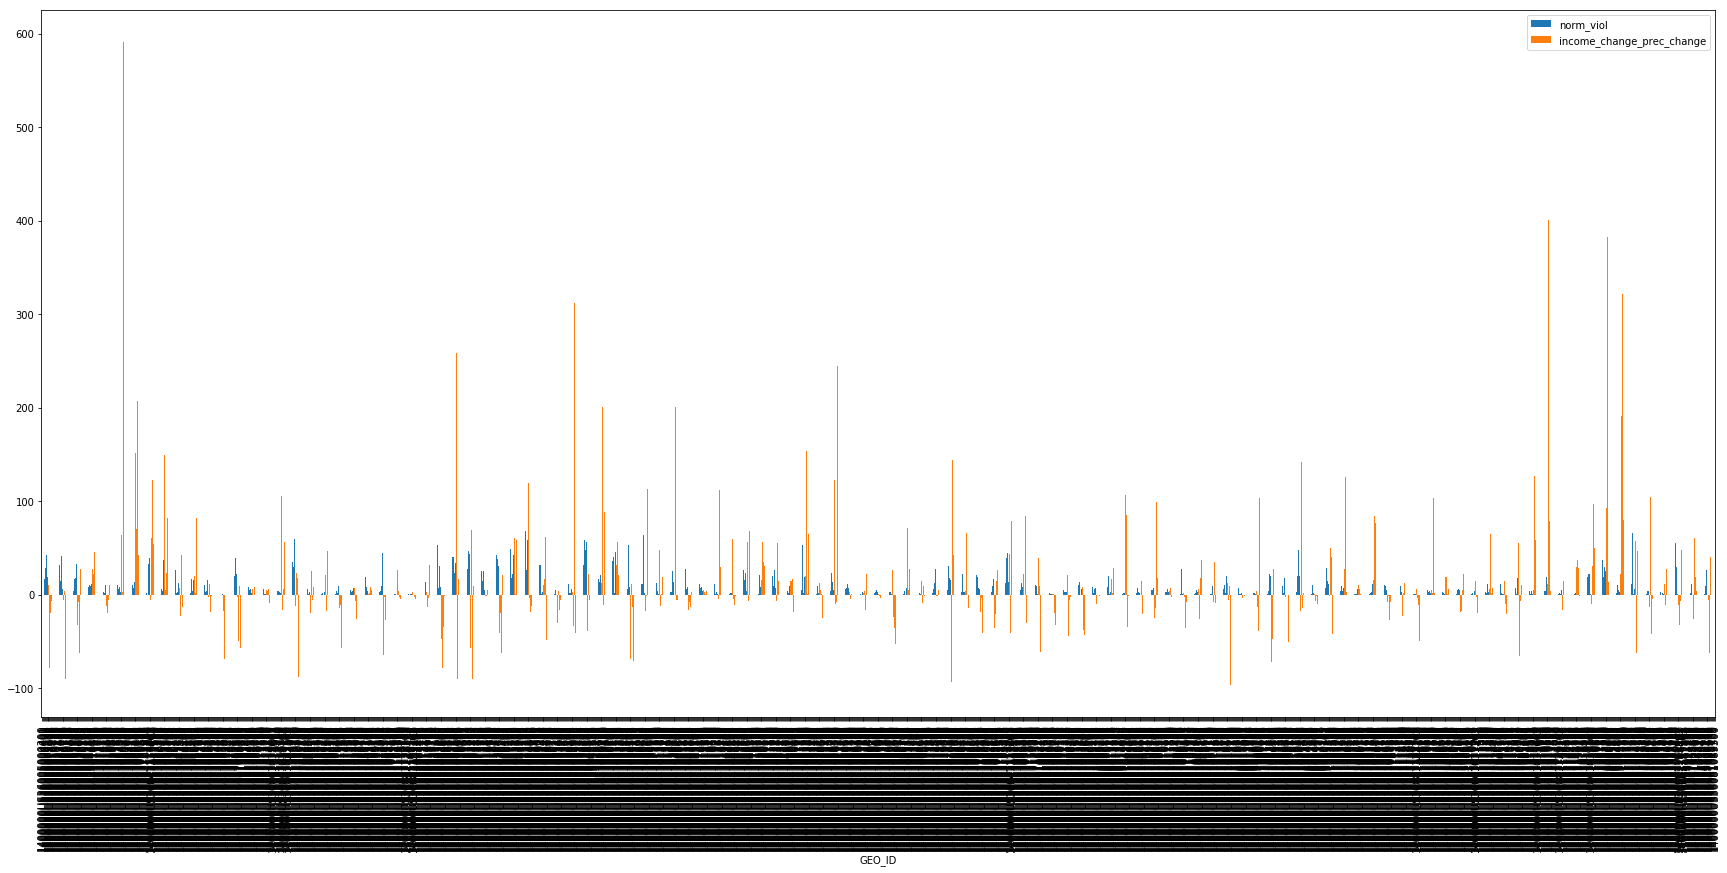

In [15]:
income_viol_units.plot(x="GEO_ID", y=["norm_viol", "income_change_prec_change"], kind="bar", figsize=(30,13))

In [16]:
# violations norm descrptives 

income_viol_units['norm_viol'].describe()

count    1789.000000
mean       11.041503
std        15.351153
min         0.000000
25%         1.629328
50%         4.896755
75%        12.978890
max       113.661202
Name: norm_viol, dtype: float64

In [17]:
#Income change describe
income_viol_units['income_change_prec_change'].describe()

count    1789.000000
mean       12.090983
std        58.980530
min       -96.385330
25%       -10.185020
50%         1.150570
75%        19.294700
max       591.025990
Name: income_change_prec_change, dtype: float64

In [18]:
#Income change describe
income_viol_units['income_change_prec_change'].describe()

count    1789.000000
mean       12.090983
std        58.980530
min       -96.385330
25%       -10.185020
50%         1.150570
75%        19.294700
max       591.025990
Name: income_change_prec_change, dtype: float64

In [19]:
#of violations per census tract describe  
income_viol_units['NUMPOINTS'].describe()

count    1789.000000
mean      176.120179
std       293.784451
min         0.000000
25%        19.000000
50%        64.000000
75%       187.000000
max      3101.000000
Name: NUMPOINTS, dtype: float64